# My Notebook
Use Austin Restaurant inspection report data and spark to get answer to critical consumer questions such as which cuisine or which area rest has more violations in past year etc...

## Jupyter Notebook
[Jupyter](https://jupyter.org/index.html) is a web-based environment for interactive computing.  Jupyter Notebook enables you to write and execute code within a "notebook" in your web browser.  You enter code into an input cell, and when you run the cell, the notebook executes the code and prints any output to an output cell.  You can change the code in an input cell and re-run the cell as often as you like.  In this way, the notebook follows a [Read Evaluate Print Loop](http://en.wikipedia.org/wiki/Read–eval–print_loop) paradigm.

Jupyter was born out of the [IPython Project](http://ipython.org) in 2014.

But that's not all.  The notebook also supports rendering markup cells (like this one) inline, so you can embed text, [markdown](http://daringfireball.net/projects/markdown/), HTML, images, videos, and even interactive widgets, all within a notebook.

The flow of a notebook is top to bottom, and you can create as many cells as you desire.  The interactive nature and the ability to render text and media makes Jupyter Notebook a powerful environment for working with data, performing analyses, and documenting results.

## Pre-requisites
<div class="alert alert-block alert-info" style="margin-top: 20px">**Note:** In the rest of the tutorial, we assume you have a basic familiarity with the Python Programming Language, the Jupyter notebook, `pandas` and `matplotlib`. If you need more background information, we recommend these websites and notebooks:
<ul>
<li>[Learn Python the Hard Way](http://learnpythonthehardway.org/book/)
<li>[Python Programming Language](https://www.python.org/)
<li>[IPython Notebook](http://nbviewer.ipython.org/github/ipython/ipython/blob/2.x/examples/Notebook/Index.ipynb)
<li>[Jupyter Notebook](http://jupyter.readthedocs.org/en/latest/)
<li> [A gallery of interesting Notebooks](https://github.com/ipython/ipython/wiki/A-gallery-of-interesting-IPython-Notebooks)
<li>[`pandas`](http://pandas.pydata.org/)
<li>[`matplotlib`](http://matplotlib.org)
</ul>
</div>

## Data set

I will use **Apache Spark** to analyze raw Restaurant Inspection Scores data from data.austintexas.gov. More specifically we use the raw restaurant scores for inspections performed within the last three years. Online search of this data set also available at: http://www.ci.austin.tx.us/health/restaurant/search.cfm

Uploaded local source: Restaurant_Inspection_Scores.csv



The format of the raw data in the base file consists of the following:

<table border="1" style="width:90%">
  <tr>
    <th>Restaurant Name</th><th>Zip Code</th><th>Inspection Date</th><th>Score</th><th>Address</th><th>Facility ID</th><th>Process Description</th>
  </tr>
  <tr>
    <td>15th Street Cafe</td><td>78701</td><td>12/5/13</td><td>97</td><td>"303 W 15TH ST
AUSTIN, TX 78701
    (30.277501963873, -97.7425547470704)"</td><td>2801033</td><td>Routine Inspection</td>
  </tr>
  <tr>
    <td>15th Street Cafe</td><td>78701</td><td>12/2/14</td><td>93</td><td>"303 W 15TH ST
AUSTIN, TX 78701
(30.277501963873, -97.7425547470704)"</td><td>2801033</td><td>Routine Inspection</td>
  </tr>
  <tr>
    <td>15th Street Cafe</td><td>78701</td><td>6/18/14</td><td>97</td><td>"303 W 15TH ST
AUSTIN, TX 78701
(30.277501963873, -97.7425547470704)"</td><td>2801033</td><td>Routine Inspection</td>
  </tr>
  <tr>
    <td>...</td><td>...</td><td>...</td><td>...</td><td>...</td><td>...</td><td>...</td>
  </tr>
</table>
<p>

where columns contain a Restaurant Name, Zip Code, Inspection Date,	Score, Address,	Facility ID, Process Description.

## Load Data
**[pandas](http://pandas-docs.github.io/pandas-docs-travis/)** is a useful Python package for managing structured data.  The two primary data structures of pandas are [`Series`](http://pandas-docs.github.io/pandas-docs-travis/dsintro.html#series) (1-dimensional) and [`DataFrame`](http://pandas-docs.github.io/pandas-docs-travis/dsintro.html#dataframe) (2-dimensional).

In the following steps, we'll load the annual precipitation CSV file into a DataFrame in memory.

Click on the play (**&#9658;**) button in the notebook **Toolbar** to run code cells. The code will be executed. During that time a `[*]` is shown on the left side to indicate that the cell is running. Once it completes, the `[*]` is replaced by a number indicating that it is the Nth cell to run in the notebook.

<div class="alert alert-block alert-info" style="margin-top: 20px">**Note:** For notebooks, many third-party Python packages are pre-installed. The **Environment** panel on the **Palette** displays a list of pre-installed packages which are important for data analysis. To see the full list of pre-installed packages, run `!pip freeze` in a code cell.</div>

### Step 1: Import packages into our notebook.
Click on the code cell below, then click the right arrow button (**&#9658;**) in the notebook **Toolbar** to run the code.

In [144]:
import requests, StringIO, pandas as pd, json, re

You have imported the `requests`, `base64`, `StringIO`, `pandas` and the `re` package and can make use of them within this notebook. Pandas is traditionally imported as `pd`. 

### Step 2: Access Object Storage

Because the CSV file is located in Object Storage, we need a helper function to access the file using provided credentials. Run the cell below to define the method `getFileContent`.


In [145]:
'''A function returning a StringIO object containg the file content.'''
def getFileContent(credentials):
    url1 = ''.join([credentials['auth_url'], '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domain_id']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()    
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                if(e2['interface']=='public'):
                    url2 = ''.join([e2['url'],'/', credentials['container'], '/', credentials['filename']])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO.StringIO(resp2.content)

### Step 3: Insert data source credentials

Click on the plus button (**+**) in the notebook **Toolbar** to create a new cell. Click the newly created cell and select **INSERT TO CODE** of the precipitation.csv file in the **Data Source** Panel of the **Palette**. The neccesary credentials for accessing precipitation.csv will then be pasted into the code cell. With the credentials for the precipitation.csv file, you can use the helper function read it into a `pandas` `DataFrame`.

In [146]:
credentials = {"tenant_id": "sa2f-bd0511e71a61b9-b13d3c6759b7",
    "tenant_id_full": "8d7c71dc-695d-4e71-aa2f-bd0511e71a61_553e8ca9-1029-44f8-8fb9-b13d3c6759b7",
    "cluster_master_url": "https://169.54.219.20:8443",
    "instance_id": "8d7c71dc-695d-4e71-aa2f-bd0511e71a61",
    "tenant_secret": "78101743-150f-4b7a-97a2-7ead689959cb",
    "plan": "ibm.SparkService.PayGoPersonalInteractive"}
credentials['auth_url'] = 'https://identity.open.softlayer.com'
credentials['domain_id'] = 'd433595fc02841f6aae1c485bfa15cbf'
credentials['username'] = 'user_210a29aa1372fdb97b8137765731325e81694d7b'
credentials['password'] = 'ES)*/lu1W94CPL&Q'
credentials['filename'] = 'Restaurant_Inspection_Scores.csv'
credentials['container'] = 'notebooks'

In [148]:
content_string = getFileContent(credentials)
df = pd.read_csv(content_string)

## Explore and Clean Data
Now that we have the data in memory, we can explore and manipulate it.

In [149]:
df.count()

Restaurant Name        22616
Zip Code               22616
Inspection Date        22616
Score                  22616
Address                22616
Facility ID            22616
Process Description    22616
dtype: int64

In [150]:
df.tail(2)

,Restaurant Name,Zip Code,Inspection Date,Score,Address,Facility ID,Process Description
22614,ZuZu Restaurant,78731,09/22/2015,93,"5770 N MOPAC EXPY\nAUSTIN, TX 78731\n(30.33880...",2801238,Routine Inspection
22615,ZuZu Restaurant,78731,12/09/2014,97,"5770 N MOPAC EXPY\nAUSTIN, TX 78731\n(30.33880...",2801238,Routine Inspection


In [151]:
df.dropna().shape

(22616, 7)

In [152]:
df.fillna(0, inplace=True)

So what does the cleaned precipitation data look like? We can peek at the data and its structure by looking at the first few rows.  The `DataFrame's` `head()` method exists for this purpose.

In [153]:
df.head(10)

,Restaurant Name,Zip Code,Inspection Date,Score,Address,Facility ID,Process Description
0,15th Street Cafe,78701,12/05/2013,97,"303 W 15TH ST\nAUSTIN, TX 78701\n(30.277501963...",2801033,Routine Inspection
1,15th Street Cafe,78701,12/02/2014,93,"303 W 15TH ST\nAUSTIN, TX 78701\n(30.277501963...",2801033,Routine Inspection
2,15th Street Cafe,78701,06/18/2014,97,"303 W 15TH ST\nAUSTIN, TX 78701\n(30.277501963...",2801033,Routine Inspection
3,15th Street Cafe,78701,05/22/2013,91,"303 W 15TH ST\nAUSTIN, TX 78701\n(30.277501963...",2801033,Routine Inspection
4,15th Street Cafe,78701,05/13/2015,97,"303 W 15TH ST\nAUSTIN, TX 78701\n(30.277501963...",2801033,Routine Inspection
5,1st Food Mart,78704,07/29/2014,90,"1410 S 1ST ST\nAUSTIN, TX 78704\n(30.250358861...",10677646,Routine Inspection
6,1st Food Mart,78704,01/16/2014,90,"1410 S 1ST ST\nAUSTIN, TX 78704\n(30.250358861...",10677646,Routine Inspection
7,1st Food Mart,78704,02/09/2015,94,"1410 S 1ST ST\nAUSTIN, TX 78704\n(30.250358861...",10677646,Routine Inspection
8,1st Food Mart,78704,07/27/2015,94,"1410 S 1ST ST\nAUSTIN, TX 78704\n(30.250358861...",10677646,Routine Inspection
9,1st Food Mart,78704,06/17/2013,100,"1410 S 1ST ST\nAUSTIN, TX 78704\n(30.250358861...",10677646,Routine Inspection


In [154]:
df['Zip Code'].values

array([78701, 78701, 78701, ..., 78731, 78731, 78731])

In [155]:
df['Process Description'].unique()

array(['Routine Inspection', '1st Follow Up to Routine of 50 - 69',
       '2nd Follow Up to 50 - 69', '1st Follow Up to Routine of 49 or less'], dtype=object)

### Plot
When working with interactive notebooks, you can decide how to present results and information. So far, we have used normal print functions which are informative. We can also choose a visual way, using the popular [`matplotlib`](http://matplotlib.org/) package to produce plots.

First, tell Jupyter to render charts inline:

In [156]:
%matplotlib inline 

In [157]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

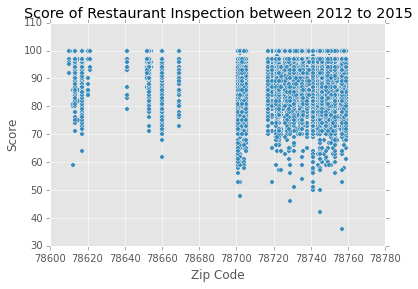

In [158]:
df.plot(kind='scatter', x='Zip Code', y='Score', title = 'Score of Restaurant Inspection between 2012 to 2015');

In [163]:
df_set = pd.DataFrame(df, columns=['Zip Code', 'Score'])
grouped = df_set.groupby('Zip Code')

In [164]:
grouped.mean()

,Score
Zip Code,
78610,97.142857
78612,81.166667
78613,93.209677
78615,85.200000
78617,92.344961
78620,91.833333
78621,97.333333
78641,95.656250
78652,96.300000


## Download Notebooks
After performing an analysis, you can download your results and insights.  In the **Menu Bar**, go to **File** and then to **Download as**. It is possible to download notebooks in various formats to your local file system.

## You want to know more?
There are interesting tutorials on YouTube:

[PyData 2015 - Introduction to Pandas](https://www.youtube.com/watch?v=TSsSWuhBpmY)

[Matplotlib Python Tutorial](https://www.youtube.com/watch?v=wAwQ-noyB98)

Please check out our [Learning Center](https://developer.ibm.com/clouddataservices/docs/spark/) for more samples, tutorials, documentation, how-tos and blog posts.